### CNN - Second model

This is the second CNN model.

In [1]:
# Using GPU to train CNN
!nvidia-smi

Sat Jun 06 17:36:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 445.87       Driver Version: 445.87       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208... WDDM  | 00000000:01:00.0  On |                  N/A |
| 17%   55C    P0    66W / 260W |    825MiB / 11264MiB |      7%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [2]:
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.models import Model, Sequential, load_model, Input
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, LeakyReLU
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.regularizers import l2
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.optimizers import Adam
from keras.models import Model
import keras
from keras import optimizers

Using TensorFlow backend.


In [3]:
# Check whether using GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
# Read images
Train=pd.read_csv('plant-pathology-2020-fgvc7/train.csv')
Test=pd.read_csv('plant-pathology-2020-fgvc7/test.csv')

In [5]:
# Resizing images
img_size=100
Train_image=[]
for name in Train['image_id']:
    path='plant-pathology-2020-fgvc7/images/'+name+'.jpg'
    img=cv2.imread(path)
    image=cv2.resize(img,(img_size,img_size),interpolation=cv2.INTER_AREA)
    Train_image.append(image)

Test_image=[]
for name in Test['image_id']:
    path='plant-pathology-2020-fgvc7/images/'+name+'.jpg'
    img=cv2.imread(path)
    image=cv2.resize(img,(img_size,img_size),interpolation=cv2.INTER_AREA)
    Test_image.append(image)

In [6]:
# Vectorizing the channels - image to array
X_train = np.ndarray(shape=(len(Train_image), img_size, img_size, 3),dtype = np.float32)
i=0
for image in Train_image:
    X_train[i]=img_to_array(image)
    X_train[i]=Train_image[i]
    i=i+1
X_train=X_train/255
print('Train Shape: {}'.format(X_train.shape))

X_test = np.ndarray(shape=(len(Test_image), img_size, img_size, 3),dtype = np.float32)
i=0
for image in Test_image:
    X_test[i]=img_to_array(image)
    X_test[i]=Test_image[i]
    i=i+1
    
X_test=X_test/255
print('Test Shape: {}'.format(X_test.shape))

Train Shape: (1821, 100, 100, 3)
Test Shape: (1821, 100, 100, 3)


In [7]:
# Deal with labels
Y = Train.copy()
del Y['image_id']
Y.head()
Y_train = np.array(Y.values)
Y_train.shape

(1821, 4)

In [8]:
# We split the training set into training and testing set
train_x,test_x,train_y,test_y = train_test_split(X_train, Y_train, test_size=0.2, random_state=0)

In [9]:
# Dealing with imbalanced dataset - oversampling
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state = 0) 
 
train_x,train_y = sm.fit_resample(train_x.reshape((-1, img_size * img_size * 3)), train_y)
train_x = train_x.reshape((-1, img_size, img_size, 3))
train_x.shape, train_y.sum(axis=0)

((1960, 100, 100, 3), array([490, 490, 490, 490]))

In [10]:
# Set early stopping and dynamic learning rates
LR_reduce=ReduceLROnPlateau(monitor='val_accuracy',
                            factor=0.5,
                            patience=10, # Change from 6
                            min_lr=0.000001, # Change from 0.00001
                            verbose=1)

In [12]:
# CNN model
reg = .0005

model = keras.Sequential()

model.add(keras.layers.Conv2D(32, kernel_size=(5,5),activation='relu', input_shape=(img_size, img_size, 3), 
                                 kernel_regularizer=tf.keras.regularizers.l2(reg)))
model.add(keras.layers.BatchNormalization(axis=-1,center=True,scale=False))
model.add(keras.layers.Conv2D(128, kernel_size=(5,5),activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg)))
model.add(keras.layers.BatchNormalization(axis=-1,center=True,scale=False))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2), padding='SAME'))
model.add(keras.layers.Dropout(.25))

model.add(keras.layers.Conv2D(128, kernel_size=(3,3),activation='relu', input_shape=(img_size, img_size, 3), 
                                 kernel_regularizer=tf.keras.regularizers.l2(reg)))
model.add(keras.layers.BatchNormalization(axis=-1,center=True,scale=False))
model.add(keras.layers.Conv2D(128, kernel_size=(3,3),activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg)))
model.add(keras.layers.BatchNormalization(axis=-1,center=True,scale=False))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2), padding='SAME'))
model.add(keras.layers.Dropout(.25))

model.add(keras.layers.Conv2D(128, kernel_size=(5,5),activation='relu', input_shape=(img_size, img_size, 3), 
                                 kernel_regularizer=tf.keras.regularizers.l2(reg)))
model.add(keras.layers.BatchNormalization(axis=-1,center=True,scale=False))
model.add(keras.layers.Conv2D(256, kernel_size=(5,5),activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg)))
model.add(keras.layers.BatchNormalization(axis=-1,center=True,scale=False))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2), padding='SAME'))
model.add(keras.layers.Dropout(.25))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(200,activation='relu'))
model.add(keras.layers.BatchNormalization(axis=-1,center=True,scale=False))
model.add(keras.layers.Dropout(.1))
model.add(keras.layers.Dense(64,activation='relu'))
model.add(keras.layers.BatchNormalization(axis=-1,center=True,scale=False))
model.add(keras.layers.Dropout(.1))
model.add(keras.layers.Dense(4,activation='softmax'))
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 96, 96, 32)        2432      
_________________________________________________________________
batch_normalization_9 (Batch (None, 96, 96, 32)        96        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 92, 92, 128)       102528    
_________________________________________________________________
batch_normalization_10 (Batc (None, 92, 92, 128)       384       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 46, 46, 128)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 46, 46, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 44, 44, 128)      

In [13]:
# Image augmentation
# Just using flipping
data_aug = ImageDataGenerator(horizontal_flip=True,
                              vertical_flip=True)

In [14]:
# Start to train model
model.fit_generator(data_aug.flow(train_x,train_y,batch_size=24), # Change from 32
                    steps_per_epoch=train_x.shape[0]//24,
                    epochs=300, # Change from 200
                    verbose=1,
                    validation_data=(test_x,test_y),
                    callbacks=[LR_reduce],
                    use_multiprocessing=False,
                    workers=1)

Epoch 1/300
81/81 [==============================] - 9s 106ms/step - loss: 1.7917 - accuracy: 0.4013 - val_loss: 4.5025 - val_accuracy: 0.0438
Epoch 2/300
81/81 [==============================] - 5s 62ms/step - loss: 1.5678 - accuracy: 0.4582 - val_loss: 3.4874 - val_accuracy: 0.0438
Epoch 3/300
81/81 [==============================] - 5s 64ms/step - loss: 1.5434 - accuracy: 0.4556 - val_loss: 4.8080 - val_accuracy: 0.0438
Epoch 4/300
81/81 [==============================] - 5s 62ms/step - loss: 1.4715 - accuracy: 0.4990 - val_loss: 2.2807 - val_accuracy: 0.1945
Epoch 5/300
81/81 [==============================] - 5s 62ms/step - loss: 1.4302 - accuracy: 0.5052 - val_loss: 2.0025 - val_accuracy: 0.2630
Epoch 6/300
81/81 [==============================] - 5s 64ms/step - loss: 1.3623 - accuracy: 0.5372 - val_loss: 2.1673 - val_accuracy: 0.2521
Epoch 7/300
81/81 [==============================] - 5s 62ms/step - loss: 1.3382 - accuracy: 0.5434 - val_loss: 1.6348 - val_accuracy: 0.4137
Epoch

81/81 [==============================] - 5s 62ms/step - loss: 0.2785 - accuracy: 0.9671 - val_loss: 1.1112 - val_accuracy: 0.7370
Epoch 58/300
81/81 [==============================] - 5s 61ms/step - loss: 0.2798 - accuracy: 0.9673 - val_loss: 0.8432 - val_accuracy: 0.8192
Epoch 59/300
81/81 [==============================] - 5s 62ms/step - loss: 0.2969 - accuracy: 0.9597 - val_loss: 1.9187 - val_accuracy: 0.6301
Epoch 60/300
81/81 [==============================] - 5s 62ms/step - loss: 0.2717 - accuracy: 0.9711 - val_loss: 0.9226 - val_accuracy: 0.8192
Epoch 61/300
81/81 [==============================] - 5s 62ms/step - loss: 0.2671 - accuracy: 0.9697 - val_loss: 0.6463 - val_accuracy: 0.8740
Epoch 62/300
81/81 [==============================] - 5s 61ms/step - loss: 0.2741 - accuracy: 0.9704 - val_loss: 0.7692 - val_accuracy: 0.8575

Epoch 00062: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 63/300
81/81 [==============================] - 5s 62ms/step - loss:

81/81 [==============================] - 5s 62ms/step - loss: 0.1008 - accuracy: 0.9979 - val_loss: 0.4909 - val_accuracy: 0.9096
Epoch 113/300
81/81 [==============================] - 5s 64ms/step - loss: 0.1009 - accuracy: 0.9964 - val_loss: 0.5038 - val_accuracy: 0.8986
Epoch 114/300
81/81 [==============================] - 5s 62ms/step - loss: 0.0972 - accuracy: 0.9969 - val_loss: 0.5037 - val_accuracy: 0.8959
Epoch 115/300
81/81 [==============================] - 5s 62ms/step - loss: 0.0981 - accuracy: 0.9959 - val_loss: 0.4930 - val_accuracy: 0.8959
Epoch 116/300
81/81 [==============================] - 5s 62ms/step - loss: 0.0923 - accuracy: 0.9979 - val_loss: 0.4896 - val_accuracy: 0.9151
Epoch 117/300
81/81 [==============================] - 5s 62ms/step - loss: 0.0931 - accuracy: 0.9985 - val_loss: 0.4924 - val_accuracy: 0.9096
Epoch 118/300
81/81 [==============================] - 5s 61ms/step - loss: 0.0935 - accuracy: 0.9979 - val_loss: 0.4915 - val_accuracy: 0.9151
Epoch 

Epoch 166/300
81/81 [==============================] - 5s 63ms/step - loss: 0.0760 - accuracy: 0.9990 - val_loss: 0.4750 - val_accuracy: 0.9123
Epoch 167/300
81/81 [==============================] - 5s 63ms/step - loss: 0.0795 - accuracy: 0.9974 - val_loss: 0.4734 - val_accuracy: 0.9123
Epoch 168/300
81/81 [==============================] - 5s 62ms/step - loss: 0.0773 - accuracy: 0.9985 - val_loss: 0.4724 - val_accuracy: 0.9123
Epoch 169/300
81/81 [==============================] - 5s 63ms/step - loss: 0.0846 - accuracy: 0.9959 - val_loss: 0.4737 - val_accuracy: 0.9123

Epoch 00169: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 170/300
81/81 [==============================] - 5s 66ms/step - loss: 0.0768 - accuracy: 0.9990 - val_loss: 0.4719 - val_accuracy: 0.9123
Epoch 171/300
81/81 [==============================] - 5s 63ms/step - loss: 0.0803 - accuracy: 0.9969 - val_loss: 0.4746 - val_accuracy: 0.9123
Epoch 172/300
81/81 [==============================] - 5s 62ms/step - l

81/81 [==============================] - 5s 61ms/step - loss: 0.0742 - accuracy: 0.9990 - val_loss: 0.4728 - val_accuracy: 0.9123
Epoch 223/300
81/81 [==============================] - 5s 62ms/step - loss: 0.0760 - accuracy: 0.9990 - val_loss: 0.4727 - val_accuracy: 0.9151
Epoch 224/300
81/81 [==============================] - 5s 61ms/step - loss: 0.0739 - accuracy: 0.9995 - val_loss: 0.4761 - val_accuracy: 0.9123
Epoch 225/300
81/81 [==============================] - 5s 68ms/step - loss: 0.0739 - accuracy: 0.9995 - val_loss: 0.4711 - val_accuracy: 0.9123
Epoch 226/300
81/81 [==============================] - 6s 72ms/step - loss: 0.0761 - accuracy: 0.9985 - val_loss: 0.4704 - val_accuracy: 0.9123
Epoch 227/300
81/81 [==============================] - 6s 69ms/step - loss: 0.0739 - accuracy: 0.9985 - val_loss: 0.4695 - val_accuracy: 0.9123
Epoch 228/300
81/81 [==============================] - 5s 62ms/step - loss: 0.0739 - accuracy: 0.9990 - val_loss: 0.4716 - val_accuracy: 0.9123
Epoch 

Epoch 279/300
81/81 [==============================] - 5s 61ms/step - loss: 0.0743 - accuracy: 0.9990 - val_loss: 0.4679 - val_accuracy: 0.9178
Epoch 280/300
81/81 [==============================] - 5s 62ms/step - loss: 0.0721 - accuracy: 0.9990 - val_loss: 0.4703 - val_accuracy: 0.9151
Epoch 281/300
81/81 [==============================] - 5s 62ms/step - loss: 0.0731 - accuracy: 0.9990 - val_loss: 0.4710 - val_accuracy: 0.9151
Epoch 282/300
81/81 [==============================] - 5s 61ms/step - loss: 0.0764 - accuracy: 0.9969 - val_loss: 0.4685 - val_accuracy: 0.9178
Epoch 283/300
81/81 [==============================] - 5s 62ms/step - loss: 0.0723 - accuracy: 0.9995 - val_loss: 0.4725 - val_accuracy: 0.9151
Epoch 284/300
81/81 [==============================] - 5s 62ms/step - loss: 0.0732 - accuracy: 0.9985 - val_loss: 0.4709 - val_accuracy: 0.9151
Epoch 285/300
81/81 [==============================] - 5s 62ms/step - loss: 0.0777 - accuracy: 0.9969 - val_loss: 0.4701 - val_accuracy:

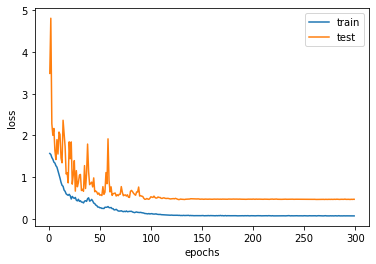

In [15]:
# Plot loss
history = model.history.history
offset = 1
epochs = range(offset, len(history['loss']))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(epochs, history['loss'][offset:], label='train')
plt.plot(epochs, history['val_loss'][offset:], label='test')
plt.legend()

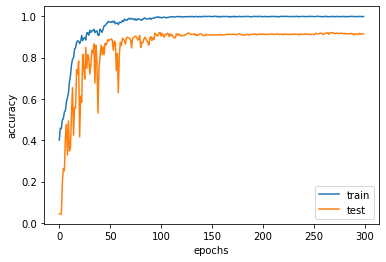

In [16]:
# plot accuracy
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(history[f'accuracy'], label='train')
plt.plot(history[f'val_accuracy'], label='test')
plt.legend()

In [17]:
Y1 = Test.copy()
del Y1['image_id']
Y1.head()
Y_test = np.array(Y1.values)
Y_test.shape

(1821, 0)

In [18]:
# predict on the testing set
predict_prob = model.predict(X_test)
df_predict_prob = pd.DataFrame(predict_prob, columns=['healthy','multiple_diseases','rust','scab'])

In [19]:
# output csv files for submission
frame = [Test['image_id'], df_predict_prob]
df_submission = pd.concat(frame, axis=1)
df_submission.to_csv(r'submisson.csv', index=False)